In [39]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace, sobel
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2

In [40]:
def gaussian_highpass(image, sigma=1.5):
    """Apply Gaussian high-pass filter to an image."""
    lowpass = gaussian_filter(image, sigma=sigma)
    highpass = image - lowpass
    return highpass

def self_quotient_image(image, sigma=1.5):
    """Compute Self-Quotient Image."""
    highpass = gaussian_highpass(image, sigma=sigma)
    local_mean = gaussian_filter(highpass, sigma=sigma)
    quotient_image = np.divide(highpass, local_mean + 1e-5)  # Avoid division by zero
    return quotient_image

def laplacian_of_gaussian(image, sigma=3.0):
    """Apply Laplacian-of-Gaussian filter to an image."""
    return laplace(gaussian_filter(image, sigma=sigma))

def gradient_filters(image):
    """Compute directional gradients of an image (x and y)."""
    grad_x = sobel(image, axis=0)
    grad_y = sobel(image, axis=1)
    return grad_x, grad_y

In [41]:
def cosine_similarity(image1, image2):
    """Calculate the cosine similarity between two images."""
    return 1 - cosine(image1.flatten(), image2.flatten())

def mutual_subspace_method(images1, images2, n_components=6):
    """Calculate MSM similarity between two sets of images."""
    pca = PCA(n_components=n_components)
    subspace1 = pca.fit_transform(images1)
    subspace2 = pca.fit_transform(images2)
    
    u, _, vh = np.linalg.svd(subspace1.T @ subspace2)
    correlations = np.diag(u.T @ vh)
    return np.mean(correlations[:3])

In [42]:
def adaptive_similarity(query_image, gallery_images, filter_function, similarity_function):
    """Calculate adaptive similarity based on confusion margin."""
    unprocessed_similarities = [similarity_function(query_image, gallery) for gallery in gallery_images]
    filtered_similarities = [similarity_function(filter_function(query_image), filter_function(gallery)) for gallery in gallery_images]
    
    # Get confusion margin
    top_similarities = sorted(unprocessed_similarities, reverse=True)[:2]
    confusion_margin = top_similarities[0] - top_similarities[1]
    
    # Weight based on confusion margin
    alpha = 1 / (1 + np.exp(-confusion_margin * 10))  # Sigmoid function as weighting function
    combined_similarity = [alpha * u + (1 - alpha) * f for u, f in zip(unprocessed_similarities, filtered_similarities)]
    
    return np.max(combined_similarity)

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D


def plot_joint_density(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(10, 6)):
    """
    Plot the joint density p(alpha, mu) as a 2D landscape.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density for the heatmap
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.imshow(
        expanded_density,
        aspect="auto",
        extent=[0, 1, 0, 1],
        origin="lower",
        cmap="viridis",
        norm=Normalize(vmin=0, vmax=np.max(expanded_density))
    )
    
    plt.colorbar(label="Density")
    plt.title(f"Joint Density Landscape at Iteration {iteration}")
    plt.xlabel("Alpha (Weight for Raw Similarity)")
    plt.ylabel("Confusion Margin")
    plt.savefig(f"joint_density_{iteration}.png")
    plt.show()


def plot_joint_density_3d(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(12, 8)):
    """
    Plot the joint density p(alpha, mu) as a 3D surface.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Create meshgrid for plotting
    alpha, margin = np.meshgrid(alpha_grid, confusion_margin)
    
    # 3D Plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha, margin, expanded_density, cmap='viridis', edgecolor='none')
    
    # Labels and title
    ax.set_title(f"Joint Density Landscape at Iteration {iteration}")
    ax.set_xlabel("Alpha (Weight for Raw Similarity)")
    ax.set_ylabel("Confusion Margin")
    ax.set_zlabel("Density")
    plt.show()


In [44]:
def estimate_joint_probability(training_data, filter_function, similarity_function, alpha_grid, n_iter=500):
    """Estimate joint probability density function p(alpha, mu) over a grid of alpha values."""
    alpha_grid = np.linspace(0, 1, alpha_grid)  # Discrete alpha values
    density = np.ones(len(alpha_grid)) / len(alpha_grid)  # Start with a uniform distribution
    
    for iterration in range(n_iter):
        query_idx = np.random.choice(len(training_data))
        # gallery_idxs = [i for i in range(len(training_data)) if i != query_idx]
        gallery_idxs = range(len(training_data))

        # print(f"Query: {query_idx}")
        # print(f"Gallery: {gallery_idxs}")
        
        # Get the confusion margin
        query_image = training_data[query_idx]
        unprocessed_similarities = [similarity_function(query_image, training_data[i]) for i in gallery_idxs]
        filtered_similarities = [similarity_function(filter_function(query_image), filter_function(training_data[i])) for i in gallery_idxs]
        
        top_similarities = sorted(unprocessed_similarities, reverse=True)[:2]
        confusion_margin = top_similarities[0] - top_similarities[1]
        
        # Compute similarity for each alpha and find the optimal alpha
        best_alpha = None
        best_ratio = -np.inf
        for i, alpha in enumerate(alpha_grid):
            combined_similarities = [alpha * u + (1 - alpha) * f for u, f in zip(unprocessed_similarities, filtered_similarities)]
            true_similarity = combined_similarities[gallery_idxs.index(query_idx)]
            max_similarity = max(combined_similarities)
            if true_similarity / (max_similarity + 1e-5) > best_ratio:
                best_ratio = true_similarity / (max_similarity + 1e-5)
                best_alpha = i
                
        density[best_alpha] += 1

        # if iterration % 50 == 0:
        #     plot_joint_density(alpha_grid, density, iterration)
    
    density /= np.sum(density)  # Normalize density
    return alpha_grid, density

In [45]:
def match_faces(query_image, gallery_images, filter_function, similarity_function, alpha_grid, density):
    """Match query face to gallery images using adaptive weighting."""
    best_similarity = -np.inf
    best_match = None
    
    for gallery_image in gallery_images:
        unprocessed_similarity = similarity_function(query_image, gallery_image)
        filtered_similarity = similarity_function(filter_function(query_image), filter_function(gallery_image))
        
        # Compute confusion margin
        confusion_margin = abs(unprocessed_similarity - filtered_similarity)
        
        # Interpolate the density to get the optimal alpha
        alpha = np.interp(confusion_margin, alpha_grid, density)
        
        combined_similarity = alpha * unprocessed_similarity + (1 - alpha) * filtered_similarity
        if combined_similarity > best_similarity:
            best_similarity = combined_similarity
            best_match = gallery_image
    
    return best_match, best_similarity

In [46]:
def load_image(filename):
    """Load an image from file."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def preview_image(image):
    """Preview an image using matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

Query image:


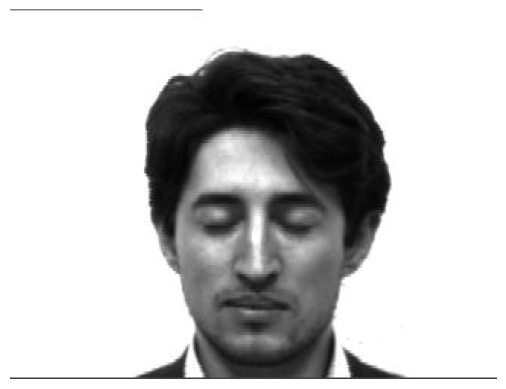

In [47]:
query_image = load_image('subject03.sleepy_frame_1.jpg')
print('Query image:')
preview_image(query_image)

Loaded 179 gallery images.
Gallery images:


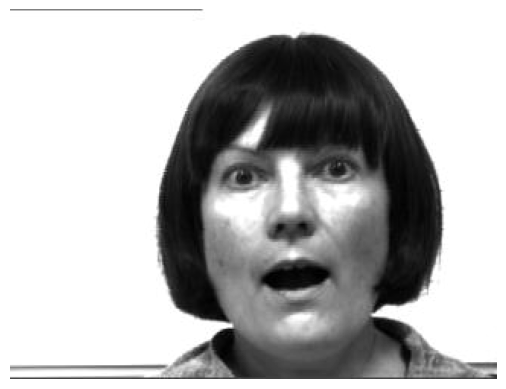

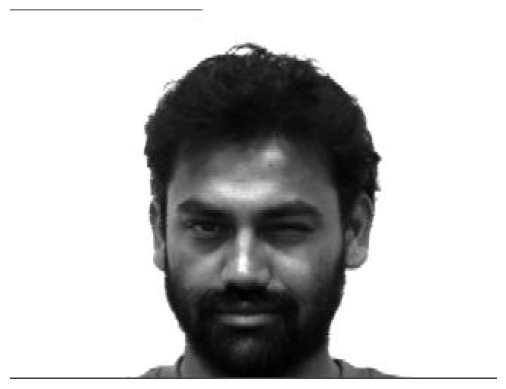

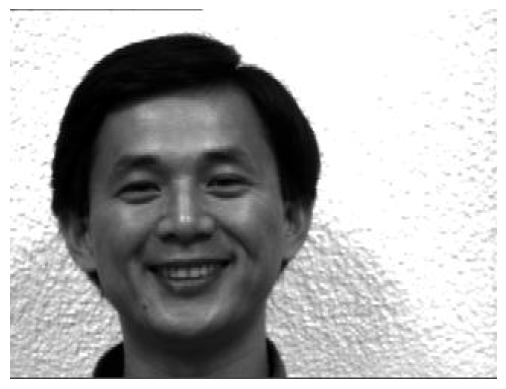

In [ ]:
# extract all file paths ending with jpg
import os
import glob
gallery_images = []
for file in glob.glob("data_new/*.jpg"):
    gallery_images.append(load_image(file))

# preview the first 3 gallery images
print(f"Loaded {len(gallery_images)} gallery images.")
# print('Gallery images:')
# for i in range(3):
#     preview_image(gallery_images[i])

/home/prakhar/courses/DIP/Illumination-invariance-face-recognition/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: overflow encountered in scalar multiply
  dist = 1.0 - uv / math.sqrt(uu * vv)
/home/prakhar/courses/DIP/Illumination-invariance-face-recognition/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: divide by zero encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


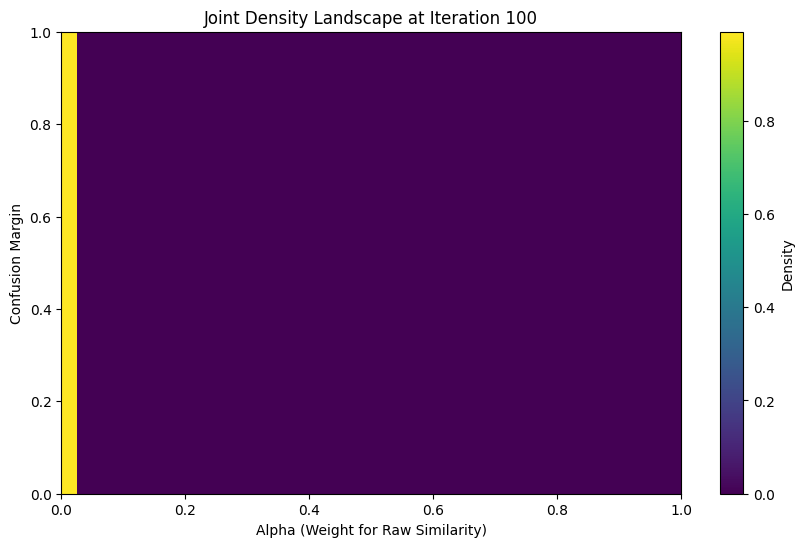

In [49]:
# Example usage with dummy data (to be replaced with actual images)
# query_image = np.random.rand(50, 50)  # Replace with actual image
# gallery_images = [np.random.rand(50, 50) for _ in range(10)]  # Replace with gallery images

ITERRATIONS = 100

alpha_grid, density = estimate_joint_probability(gallery_images, self_quotient_image, cosine_similarity, alpha_grid=40, n_iter=ITERRATIONS)
best_match, similarity_score = match_faces(query_image, gallery_images, self_quotient_image, cosine_similarity, alpha_grid, density)

plot_joint_density(alpha_grid, density, ITERRATIONS)
plot_joint_density_3d(alpha_grid, density, ITERRATIONS)


Query image:


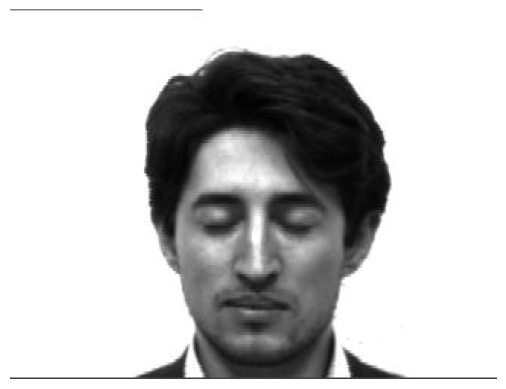

Best match:


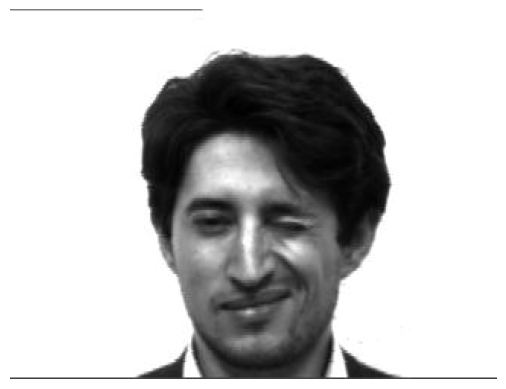

Best Match Similarity Score: 0.8453731119237562


In [54]:
print('Query image:')
preview_image(query_image)

print('Best match:')
preview_image(best_match)

print("Best Match Similarity Score:", similarity_score)
